<a href="https://colab.research.google.com/github/xoxominji/22-1-ESAA-Practice/blob/main/0624_%EB%B0%95%EB%AF%BC%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [필사]

## 파이썬 딥러닝 텐서플로 PART04 합성곱 신경망

### 4.4 위성 이미지 분류

텐서플로 데이터셋 로드

In [ ]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [ ]:
#EuroSAT  위성 사진 데이터셋 로드

DATA_DIR = "dataset/"   

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True, 
                                        as_supervised=True,
                                        with_info=True,
                                        data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incompleteC84BLY/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
# 메타데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

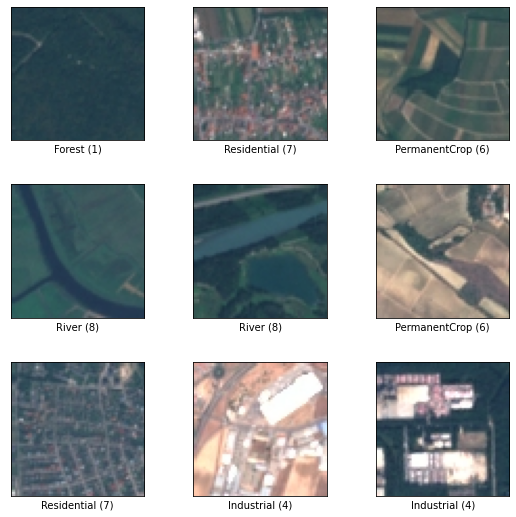

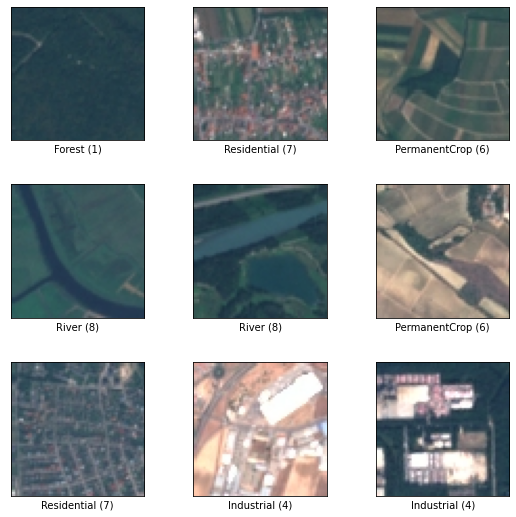

In [ ]:
# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,9 (SeaLake)
1,,8 (River)
2,,9 (SeaLake)
3,,9 (SeaLake)
4,,9 (SeaLake)
5,,0 (AnnualCrop)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,0 (AnnualCrop)
9,,2 (HerbaceousVegetation)

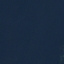
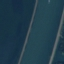
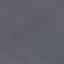
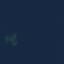
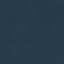
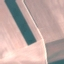
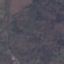
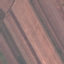
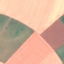
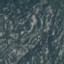

In [ ]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [ ]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [ ]:
# 숫자 레이블을 활용하여 문자열 메타데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


데이터 전처리

In [ ]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

모델 학습

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=50)             

Epoch 1/50
338/338 [==============================] - 230s 675ms/step - loss: 1.5842 - accuracy: 0.4506 - val_loss: 1.6934 - val_accuracy: 0.4756
Epoch 2/50
338/338 [==============================] - 164s 484ms/step - loss: 1.2337 - accuracy: 0.5682 - val_loss: 0.9602 - val_accuracy: 0.6781
Epoch 3/50
338/338 [==============================] - 219s 647ms/step - loss: 1.0705 - accuracy: 0.6227 - val_loss: 0.8341 - val_accuracy: 0.7394
Epoch 4/50
338/338 [==============================] - 180s 533ms/step - loss: 0.9546 - accuracy: 0.6660 - val_loss: 0.6930 - val_accuracy: 0.7815
Epoch 5/50
338/338 [==============================] - 165s 486ms/step - loss: 0.8569 - accuracy: 0.7084 - val_loss: 0.6664 - val_accuracy: 0.7974
Epoch 6/50
338/338 [==============================] - 157s 464ms/step - loss: 0.7707 - accuracy: 0.7376 - val_loss: 0.5765 - val_accuracy: 0.8237
Epoch 7/50
338/338 [==============================] - 157s 463ms/step - loss: 0.7067 - accuracy: 0.7598 - val_loss: 0.5575 -

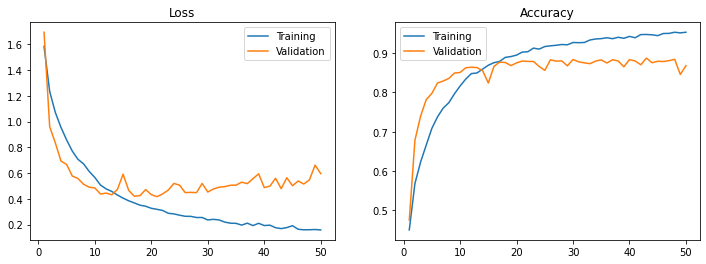

In [ ]:
# 손실함수, 정확도 그래프 그리기 

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 50)

데이터 증강

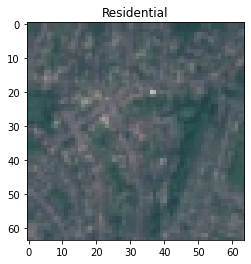

In [ ]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

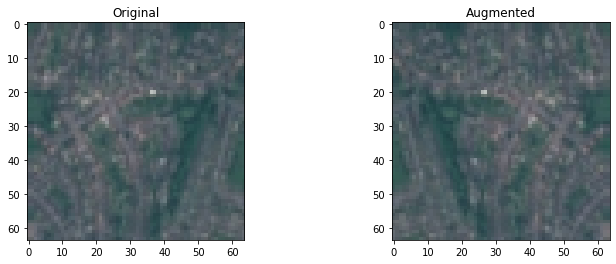

In [ ]:
# 좌우 뒤집기 
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

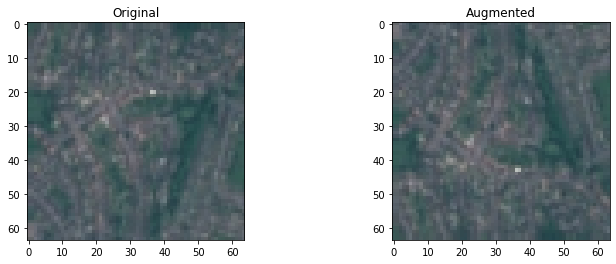

In [ ]:
# 상하 뒤집기 
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

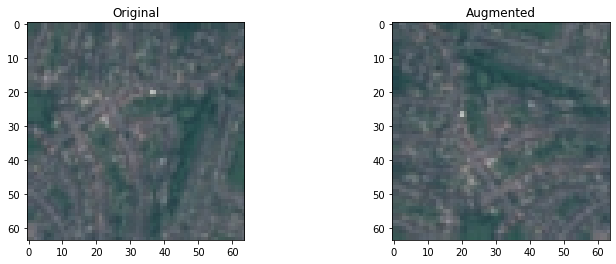

In [ ]:
# 회전 
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

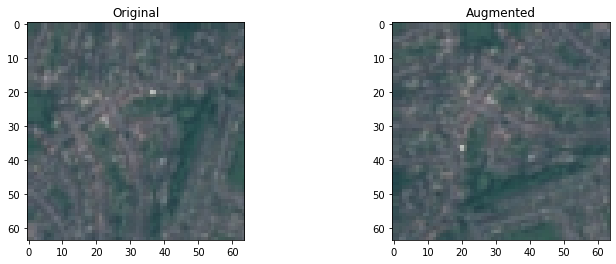

In [ ]:
# transpose 
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

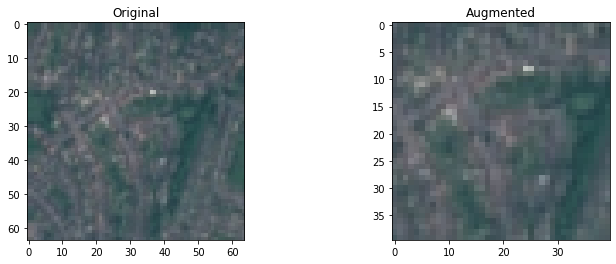

In [ ]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

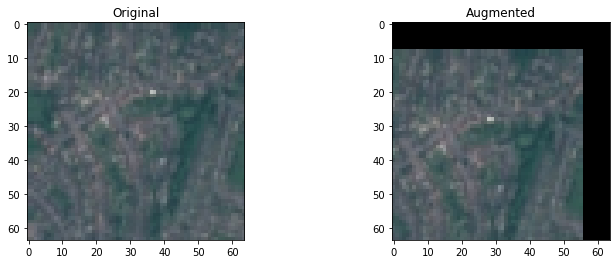

In [ ]:
# 이미지 자르기 2 
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

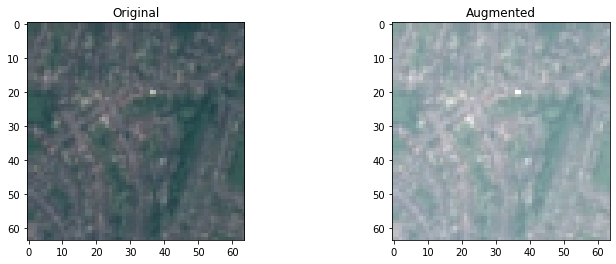

In [ ]:
# 이미지 밝기 
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

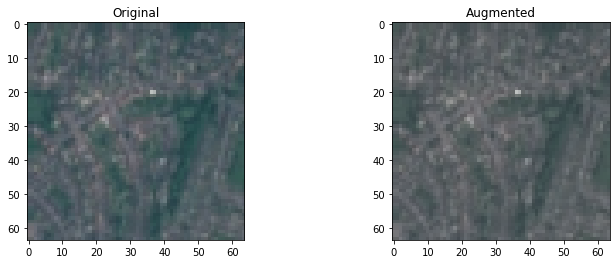

In [ ]:
# 이미지 채도 
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

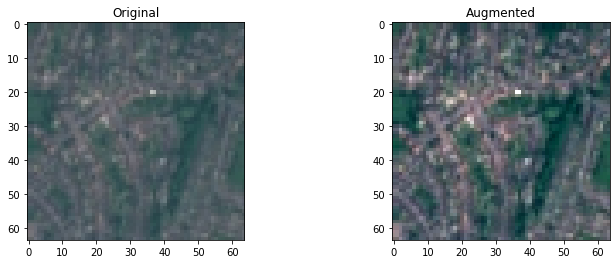

In [ ]:
# 이미지 대비  
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [ ]:
# 이미지 증강 전처리
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, 
                            validation_data=valid_aug, 
                            epochs=50)      

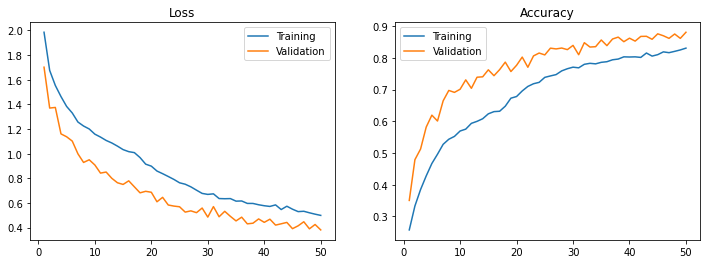

In [ ]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(aug_history, 50)

전이 학습(Transfer Learning)

In [ ]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, 
                               weights='imagenet',
                               input_shape=[64, 64, 3])
, 
# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

ImportError: ignored

In [ ]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base 
        pre_trained_base,
        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()    
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [ ]:
# 모델 컴파일
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
tc_history = tc_model.fit(train_aug, 
                          validation_data=valid_aug, 
                          epochs=50)      

Epoch 1/50
338/338 [==============================] - 278s 810ms/step - loss: 1.0419 - accuracy: 0.6631 - val_loss: 0.6002 - val_accuracy: 0.8078
Epoch 2/50
338/338 [==============================] - 274s 808ms/step - loss: 0.7275 - accuracy: 0.7670 - val_loss: 0.5154 - val_accuracy: 0.8324
Epoch 3/50
338/338 [==============================] - 273s 808ms/step - loss: 0.6409 - accuracy: 0.7944 - val_loss: 0.4816 - val_accuracy: 0.8374
Epoch 4/50
338/338 [==============================] - 273s 808ms/step - loss: 0.5973 - accuracy: 0.8075 - val_loss: 0.4613 - val_accuracy: 0.8443
Epoch 5/50
338/338 [==============================] - 272s 804ms/step - loss: 0.5566 - accuracy: 0.8200 - val_loss: 0.4613 - val_accuracy: 0.8417
Epoch 6/50
338/338 [==============================] - 272s 805ms/step - loss: 0.5403 - accuracy: 0.8223 - val_loss: 0.4435 - val_accuracy: 0.8507
Epoch 7/50
338/338 [==============================] - 272s 805ms/step - loss: 0.5206 - accuracy: 0.8306 - val_loss: 0.4380 -

In [ ]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(tc_history, 50)

NameError: ignored

# DACON [필사] 
## [Baseline] 2. 전이학습(transfer learning)을 통한 이미지 분류

In [2]:
#필요한 library 들을 load 합니다.
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import random
import numpy as np
from tqdm import tqdm

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from multiprocessing import cpu_count
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn import CrossEntropyLoss
from torchvision.models import efficientnet_b3 as efficientnet
from sklearn.model_selection import train_test_split

데이터 load, 전처리

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), #이미지 데이터를 tensor 데이터 포멧으로 바꾸어줍니다.
    transforms.Resize([224,224]), #이미지의 크기가 다를 수 있으니 크기를 통일해 줍니다.
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #픽셀 단위 데이터를 정규화 시켜줍니다.
])

데이터를 불러와 줍니다.

PYTORCH 의 ImageFolder 메소드를 사용하면 folder 의 이름을 자동으로 라벨링이 됩니다.

예를 들어 airplane 이라는 folder 내에 이미지 파일들이 있다면, 이미지 파일들의 라벨을 '0' 으로 라벨링이 됩니다.

데이터가 없으므로 코드만 필사 진행하였다.

In [ ]:
import tensorflow as tf

(training_images, training_labels), (test_images,test_idx) = tf.keras.datasets.cifar10.load_data()

In [ ]:
train_data = datasets.ImageFolder(root='./data/train/',transform=transform)

In [ ]:
train_idx, valid_idx = train_test_split(np.arange(len(train_data)), test_size=0.2, 
                                        random_state=42, shuffle=True, stratify=train_data.targets)

In [ ]:
batch_size = 32 #하드웨어에 한번에 load 할 데이터의 크기
num_workers = int(cpu_count() / 2) #데이터 로드 멀티 프로세싱을 위한 파라미터

In [ ]:
#데이터 셋을 순회하며 모델에 데이터를 넣어주는 객체
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(train_idx), num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(valid_idx), num_workers=num_workers)

In [ ]:
#데이터 크기
train_total = len(train_idx)
valid_total = len(valid_idx)

train_batches = len(train_loader)
valid_batches = len(valid_loader)

In [ ]:
print('total train imgs :',train_total,'/ total train batches :', train_batches)
print('total valid imgs :',valid_total, '/ total valid batches :', valid_batches)

Device 설정

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

모델 불러오기 / 파라미터 설정

전이학습을 위한 모델을 load

PYTORCH 의 models 메소드를 사용하면 손쉽게 외부의 모델을 불러올 수 있음

이번 베이스라인에서는 efficientnet_b3 모델을 사용해 볼 것

사전 학습 모델을 사용하는 것은 부정행위에 해당하니, pretrained 파라미터를 False 로 설정해야 함!

pretrained 파라미터를 True 로 설정한다면, ImageNet 이라는 데이터셋을 대상으로 학습된 모델이 load

반면, pretrained 파라미터를 False 로 설정한다면, 모델의 구조만 load 되고 모델의 가중치 들은 load 안됨

In [ ]:
net = models.efficientnet_b3(pretrained=False)
net.classifier

In [ ]:
net.fc = nn.Linear(1000, 10)
net = net.to(device) 

In [ ]:

criterion = CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)
epochs = 10

학습

In [ ]:
for epoch in range(epochs):
    net.train()
    
    train_loss = 0 
    train_correct = 0
    tqdm_dataset = tqdm(train_loader)
    for x,y in tqdm_dataset:
        x = x.to(device)
        y = y.to(device)
        outputs = net(x)
        loss = criterion(outputs,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(y).sum().item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(loss.item()),
        })

    train_loss = train_loss / train_batches
    train_acc = train_correct / train_total
    
    net.eval()
    
    valid_loss = 0 
    valid_correct = 0
    tqdm_dataset = tqdm(valid_loader)
    with torch.no_grad():
        for x,y in tqdm_dataset:
            x = x.to(device)
            y = y.to(device)
            
            outputs = net(x)
            loss = criterion(outputs, y)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            valid_correct += predicted.eq(y).sum().item()
            
            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Loss': '{:06f}'.format(loss.item()),
            })
            
    valid_loss = valid_loss / valid_batches
    valid_acc = valid_correct / valid_total
        
    print('epochs',epoch+1, 'train loss',train_loss,'train acc', train_acc, 'valid loss',valid_loss, 'valid acc',valid_acc)

모델 저장 / 불러오기

In [ ]:
path = './model.pth'
torch.save(net.state_dict(),path)

In [ ]:
path = './model.pth'
net.load_state_dict(torch.load(path))

추론

In [ ]:
from glob import glob
import PIL.Image
import numpy as np

test_images = []

path = './data/'
for filename in sorted(glob(path + "test/*.jpg")):
    an_img = PIL.Image.open(filename) 
    img_array = np.array(an_img) 
    test_images.append(img_array) 

test_images = np.array(test_images)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, transform):
        self.transform = transform 
        self.img_list = test_images
        self.img_labels = [0] * 10000 

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.transform(self.img_list[idx]), self.img_labels[idx]

In [ ]:
test_set = CustomDataset(transform)

In [ ]:
test_loader = DataLoader(test_set, batch_size = batch_size, num_workers=num_workers)

In [ ]:
# 데이터가 backpropagation 되어 가중치가 수정되지 않도록 해주는 코드
import pandas as pd
sample_submission = pd.read_csv('./data/sample_submission.csv')

net.eval()

batch_index = 0

for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    outputs = net(images)
    batch_index = i * batch_size
    max_vals, max_indices = torch.max(outputs, 1)
    sample_submission.iloc[batch_index:batch_index + batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

In [ ]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sample_submission['target'] = sample_submission['target'].map(labels)

In [ ]:
sample_submission.head()